In [1]:
import json
import numpy as np
import pandas as pd
import pickle

from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, metrics, decomposition, model_selection

# DoE

In [2]:
df = pd.read_csv('./results/results_complete.csv', parse_dates=['start_time', 'end_time'])
df.head()

,cores,parallelization,batch_size,learning_rate,max_epoch,start_time,end_time,duration
0,1,1,32,0.01,5,2021-10-24 05:09:49+00:00,2021-10-24 05:16:47+00:00,418
1,1,1,32,0.01,5,2021-10-24 22:46:19+00:00,2021-10-24 22:53:33+00:00,434
2,1,1,32,0.01,5,2021-10-24 22:54:07+00:00,2021-10-24 23:01:05+00:00,418
3,1,1,32,0.01,20,2021-10-24 05:17:24+00:00,2021-10-24 05:42:48+00:00,1524
4,1,1,32,0.01,20,2021-10-24 23:01:56+00:00,2021-10-24 23:29:26+00:00,1650


In [3]:
df.drop(['start_time', 'end_time'], axis=1, inplace=True)

In [4]:
df = df.groupby(['cores', 'parallelization', 'batch_size', 'learning_rate', 'max_epoch'], sort=False, as_index=False).mean().round(2)
df.head()
# df.to_csv('./results/results.csv')

,cores,parallelization,batch_size,learning_rate,max_epoch,duration
0,1,1,32,0.01,5,423.33
1,1,1,32,0.01,20,1587.67
2,1,1,32,0.05,5,404.33
3,1,1,32,0.05,20,1555.33
4,1,1,256,0.01,5,330.67


# Queueing Theory

In [5]:
FMT = '%Y-%m-%dT%H:%M:%SZ'

In [6]:
# job_names = []
# arrival_times = []
# start_times = []
# end_times = []

# with open('../queue_2/20.json', 'r') as f:
#     data = json.load(f)

# for item in data['items']:
#     job_names.append(item['metadata']['name'])
#     for status in item['status']['conditions']:
#         if status['type'] == 'Created':
#             arrival_times.append(dt.strptime(status['lastUpdateTime'], FMT))
#         elif status['type'] == 'Running':
#             start_times.append(dt.strptime(status['lastUpdateTime'], FMT))
#         else:
#             end_times.append(dt.strptime(status['lastUpdateTime'], FMT))

# df = pd.DataFrame({'Name':job_names, 'Created':arrival_times, 'Start':start_times, 'Completed':end_times})
# df.sort_values(['Created'], axis=0)
# df['ServiceTime'] = (df['Completed'] - df['Start']).apply(lambda x:x.seconds)
# df['WaitTime'] = (df['Start'] - df['Created']).apply(lambda x:x.seconds)
# df['ResponseTime'] = (df['Completed'] - df['Created']).apply(lambda x:x.seconds)
# df

In [7]:
# total_time = (df['Completed'].max() - df['Created'].min()).seconds
# busy_time = df['ServiceTime'].sum()
# utilization = busy_time / total_time
# print(f'Utilization = {busy_time} / {total_time} = {utilization}')
# average_resp_time = df['ResponseTime'].mean()
# print(f'Average Response Time = {average_resp_time}')

In [8]:
# df['ServiceTime'].mean()

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

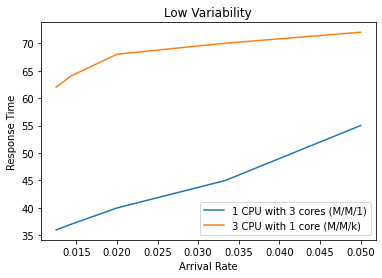

In [10]:
x_1 = np.array([80,70,50,30,20]) # Interarrival time
x_1 = 1 / x_1 # Arrival Rate
plt.plot(x_1, [36,37,40,45,55], label="1 CPU with 3 cores (M/M/1)")
plt.plot(x_1, [62,64,68,70,72], label="3 CPU with 1 core (M/M/k)")

plt.xlabel("Arrival Rate")
plt.ylabel("Response Time")
plt.title('Low Variability')
plt.legend()
plt.savefig('./plots/lowVar.png', dpi=300)
plt.savefig('./plots/lowVar.jpg', dpi=300)
plt.show()

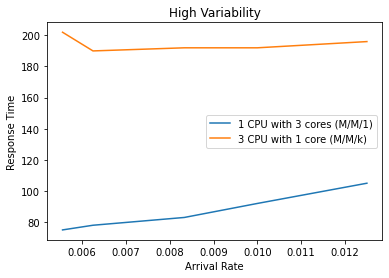

In [11]:
x_1 = np.array([180,160,120,100,80]) # Interarrival time
x_1 = 1 / x_1 # Arrival Rate
plt.plot(x_1, [75,78,83,92,105], label="1 CPU with 3 cores (M/M/1)")
plt.plot(x_1, [202,190,192,192,196], label="3 CPU with 1 core (M/M/k)")

plt.xlabel("Arrival Rate")
plt.ylabel("Response Time")
plt.title('High Variability')
plt.legend()
plt.savefig('./plots/highVar.png', dpi=300)
plt.savefig('./plots/highVar.jpg', dpi=300)
plt.show()

# Machine Learning

In [12]:
# Get the dataset loaded and define class labels
data = pd.read_csv('./results/results_complete.csv')
data.head()

,cores,parallelization,batch_size,learning_rate,max_epoch,start_time,end_time,duration
0,1,1,32,0.01,5,2021-10-24 05:09:49+00:00,2021-10-24 05:16:47+00:00,418
1,1,1,32,0.01,5,2021-10-24 22:46:19+00:00,2021-10-24 22:53:33+00:00,434
2,1,1,32,0.01,5,2021-10-24 22:54:07+00:00,2021-10-24 23:01:05+00:00,418
3,1,1,32,0.01,20,2021-10-24 05:17:24+00:00,2021-10-24 05:42:48+00:00,1524
4,1,1,32,0.01,20,2021-10-24 23:01:56+00:00,2021-10-24 23:29:26+00:00,1650


In [13]:
data.drop(['start_time', 'end_time'], axis=1, inplace=True)

In [14]:
# All data columns except last are input features (X), last column is output label (y)
feature_names = data.columns
n_features = len(data.columns) - 1
X = data.iloc[:, 0:n_features].values
y = data.iloc[:, n_features].values

In [15]:
# X = preprocessing.StandardScaler().fit_transform(X)

In [16]:
# Split data in training and testing for 0.33 ratio of testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
print('X train {}'.format(X_train.shape))
print('X test{}'.format(X_test.shape))
print('y train {}'.format(y_train.shape))
print('y train {}'.format(y_test.shape))

X train (64, 5)
X test(32, 5)
y train (64,)
y train (32,)


In [17]:
# MODEL CREATION
mlp = MLPRegressor()
rf = RandomForestRegressor()
lr = LinearRegression()
logr = LogisticRegression()
lasso = Lasso()

In [18]:
# PARAMETER TRAINING

# MLP
mlp.fit(X_train,y_train)

# Linear Regression
lr.fit(X_train,y_train)

# Logistic Regressor
logr.fit(X_train,y_train)

# Lasso Regressor
lasso.fit(X_train,y_train)

# Random Forest Regressor
rf.fit(X_train,y_train)

D:\InstalledSoftware\Anaconda3\envs\qpecs\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\InstalledSoftware\Anaconda3\envs\qpecs\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestRegressor()

In [19]:
# INFERENCE

# MLP
y_mlp = mlp.predict(X_test)

# Linear Regression
y_lr = lr.predict(X_test)

# Logistic Regressor
y_logr = logr.predict(X_test)

# Lasso Regressor
y_lasso = lasso.predict(X_test)

# Random Forest Regressor
y_rf = rf.predict(X_test)

In [20]:
# ERROR MEASURE
mae = []
mae.append(metrics.mean_absolute_error(y_test, y_mlp))
mae.append(metrics.mean_absolute_error(y_test, y_lr))
mae.append(metrics.mean_absolute_error(y_test, y_logr))
mae.append(metrics.mean_absolute_error(y_test, y_lasso))
mae.append(metrics.mean_absolute_error(y_test, y_rf))

mse = []
mse.append(metrics.mean_squared_error(y_test, y_mlp))
mse.append(metrics.mean_squared_error(y_test, y_lr))
mse.append(metrics.mean_squared_error(y_test, y_logr))
mse.append(metrics.mean_squared_error(y_test, y_lasso))
mse.append(metrics.mean_squared_error(y_test, y_rf))

r2 = []
r2.append(metrics.r2_score(y_test,y_mlp))
r2.append(metrics.r2_score(y_test,y_lr))
r2.append(metrics.r2_score(y_test,y_logr))
r2.append(metrics.r2_score(y_test,y_lasso))
r2.append(metrics.r2_score(y_test,y_rf))

In [21]:
pd.DataFrame({'Model':['MLP', 'Linear Regressor', 'Logistic Regressor', 'Lasso', 'Random Forest'], 'MAE': mae, 'MSE':mse, 'R2':r2})

,Model,MAE,MSE,R2
0,MLP,402.917569,374509.280669,-0.504141
1,Linear Regressor,177.213497,56493.518108,0.773105
2,Logistic Regressor,101.750000,25660.250000,0.896941
3,Lasso,172.287139,54927.668853,0.779394
4,Random Forest,25.510738,2206.500444,0.991138


In [22]:
rf.feature_importances_

array([0.24009859, 0.30547099, 0.02387661, 0.00301698, 0.42753682])

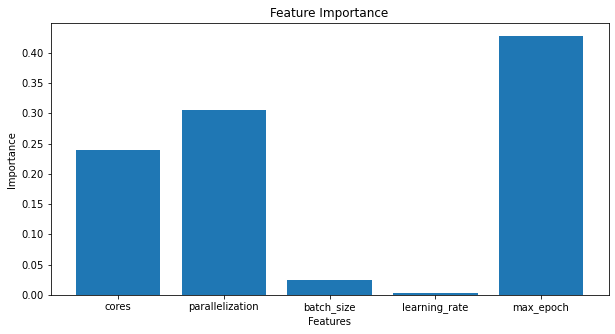

In [23]:
plt.figure(figsize=(10, 5))
plt.bar(feature_names[:-1], rf.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('./plots/featImp.png', dpi=300)
plt.savefig('./plots/featImp.jpg', dpi=300)
plt.show()

In [24]:
# save RF Model
pickle.dump(rf, open('./models/model.pkl', 'wb'))

In [40]:
rf_demo = pickle.load(open("./models/model.pkl", "rb"))
x_demo = np.array([[8,4,32,0.01,5]])
y_demo = rf_demo.predict(x_demo)
y_demo[0]

72.40028571428572

# Optimization

In [70]:
df = pd.read_csv('./results/log_random.csv', parse_dates=['start_time', 'end_time'])
df['duration'] = df['end_time'] - df['start_time']
df['duration'] = df['duration'].apply(lambda x:x.seconds)
df.drop(['job_name', 'end_time', 'start_time'], axis=1, inplace = True)
per = df[df['duration'] < 250].shape[0] / df.shape[0]
print(f'Percentage of jobs satisfying condition is {round(per*100)} %')

Percentage of jobs satisfying condition is 50 %


In [72]:
df = pd.read_csv('./results/log_optimizer.csv', parse_dates=['start_time', 'end_time'])
df['duration'] = df['end_time'] - df['start_time']
df['duration'] = df['duration'].apply(lambda x:x.seconds)
df.drop(['job_name', 'end_time', 'start_time'], axis=1, inplace = True)
per = df[df['duration'] < 250].shape[0] / df.shape[0]
print(f'Percentage of jobs satisfying condition is {round(per*100)} %')

Percentage of jobs satisfying condition is 83 %
